<a href="https://colab.research.google.com/github/solozano0725/diplomadoMLNivel1/blob/main/DipMLsesion20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **Diplomado de Análisis de datos y Machine Learning en Python**


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

## **Sesión 20**

## **Contenido**

- <a href="#met"> Métricas</a><br>
  - <a href="#acc"> *Accuracy*</a><br>
  - <a href="#mat"> Matriz de confusión</a><br>
  - <a href="#pre"> *Precision* & *Recall*</a><br>
  - <a href="#cur"> Curva ROC</a><br>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

from mlxtend.plotting import plot_decision_regions

<p><a name="acc"></a></p>

# **Métricas**

En Machine Learning, la métrica que elejimos determina directamente el tipo de solución que obtenemos. Por lo tanto, las métricas en Machine Learning no son herramientas auxiliares para evaluar una solución, sino que son lo que *guía* el proceso de encontrar una solución.

Vamos a utilizar un conjunto de datos para predicción de cancer de mama con el objetivo ejemplificar los diferentes aspectos que se deben tener en cuenta a la hora de evaluar un modelo de clasificación








In [ ]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Como vemos, el conjunto de datos contiene una serie de características numéricas para predecir si una persona tiene un cancer maligno (*malignant*) o benigno (*benign*). 

Separemos los datos en los conjuntos de entrenamiento y de prueba

In [ ]:
# train and test sets
X = df
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Recuerde que la función `train_test_split` realiza un separamiento *estratificado*. 

Construyamos tres modelos de clasificación

In [ ]:
# classifiers
lr_clf = make_pipeline(StandardScaler(), 
                       LogisticRegression()).fit(X_train, y_train)

svm_clf = make_pipeline(StandardScaler(), 
                        SVC()).fit(X_train, y_train)
                        
nb_clf = GaussianNB().fit(X_train, y_train)

# **Accuracy**: 

La [métrica](https://scikit-learn.org/stable/modules/model_evaluation.html) que se utiliza por defecto cuando se utiliza el método `score` es el *accuracy*, que es la fracción de muestras clasificadas correctamente

$$\text{accuracy} = \frac{\text{clasificados bien}}{\text{total}}$$

veamos el *accuracy* para los tres modelos:

In [ ]:
print(f"Logistic Regression: \t {lr_clf.score(X_test, y_test):.2f}")
print(f"Support Vector Machines: {svm_clf.score(X_test, y_test):.2f}")
print(f"Naive Bayes: \t\t {nb_clf.score(X_test, y_test):.2f}")

Logistic Regression: 	 0.97
Support Vector Machines: 0.98
Naive Bayes: 		 0.97


Alternativamente, podemos utilizar una validación cruzada para tener una mejor evaluación del modelo, la cuál también utiliza por defecto el *accuracy* como métrica de rendimiento cuando la tarea es de clasificación (puede utilizar el parámetro `scoring` para elegir la métrica):

In [ ]:
print(f"Logistic Regression: \t {cross_val_score(lr_clf, X, y).mean():.2f}")
print(f"Support Vector Machines: {cross_val_score(svm_clf, X, y).mean():.2f}")
print(f"Naive Bayes: \t\t {cross_val_score(nb_clf, X, y).mean():.2f}")

Logistic Regression: 	 0.98
Support Vector Machines: 0.97
Naive Bayes: 		 0.94


De aquí vemos que, aunque el clasificador NB generalizaba bien para la elección particular de conjuntos de entrenamiento y validación que construímos, una vez se utiliza todo el conjunto de datos se evidencia que es mucho más sensible a los datos de entrada y su rendimiento real está por debajo de los demás clasificadores.

La principal ventaja del *accuracy* es que es muy fácil de interpretar ya que mide lo que realmente se desea lograr en general: acertar en la clasificación tantas veces como sea posible. Sin embargo, si evaluamos el rendimiento de un modelo de clasificación utilizando solo el *accuracy* veremos que, en la práctica, esta métrica de evaluación puede no ser apropiada para el objetivo que se tenga. 

El *accuracy* es una métrica útil cuando los errores en la predicción de todas las clases se consideran **igualmente importantes**. En el caso de la predicción de una enfermedad, esta métrica no será tan útil.

Recordemos que para la clasificación binaria, hablamos de una clase positiva y una clase negativa. En este caso, si la prueba es negativa, se supondrá que el paciente está sano, mientras que si la prueba es positiva, el paciente se someterá a una evaluación adicional. Llamaremos a una prueba positiva (una indicación de cáncer) la clase positiva, y una prueba negativa a la clase negativa. 

Ahora, no podemos suponer que nuestro modelo siempre funcionará perfectamente; este cometerá errores. Para cualquier aplicación, debemos preguntarnos cuáles son las consecuencias de estos errores en el mundo real. Los posibles errores en nuestro caso son: 

Un posible error es que un paciente sano se clasifique como positivo, que como dijimos llevaría a pruebas adicionales. Esto conlleva algunos costos e inconvenientes para el paciente. Una predicción positiva incorrecta se llama **falso positivo (FP)**. El otro posible error es que un paciente enfermo se clasifique como negativo, es decir como no enfermo, por lo que no recibirá más pruebas ni tratamiento, lo que podría llevarlo a la muerte ya que no recibirá tratamiento. Un error de este tipo (una predicción negativa incorrecta) se llama *falso negativo*

* **Falso positivo (FP)**: Un paciente sano se clasifica como positivo 

* **Falso negativo (FN)**: Un paciente enfermo se clasifica como negativo

El problema con el *accuracy* es que encapsula los diferentes tipos de errores en el mismo número

$$\text{accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

donde **TP** (*true positive*) y **TN** (*true negative*) son las clasificaciones correctas. Sin embargo, en este caso, necesitamos métricas alternativas que nos permitan evaluar los posibles errores de forma independiente para guiar el modelo a que tolere más los falsos positivos que los falsos negativos.





Por otro lado, el *accuracy* no es una buena métrica de rendimiento cuando los datos están desbalanceados, es decir, conjuntos de datos en los que una clase es mucho más frecuente que la otra, ya que esta, como vemos, mide el rendimiento del modelo para todas las clases a la vez y devuelve convenientemente un solo número. 

En la práctica, los datos no balanceados son la norma, y es raro que los eventos de interés tengan una frecuencia igual o incluso similar en los datos.

Veamos que el conjunto de datos que estamos tratando es en efecto desbalanceado:

In [ ]:
print(f"clases positivas: {y_train.sum()}") 
print(f"clases negativas: {y_train.size - y_train.sum()}")

clases positivas: 286
clases negativas: 169


construyamos un clasificador *dummy* que clasifique cada instancia como la clase con mayor frecuencia (clase positiva). Para esto podemos utilizar el estimador `DummyClassifier` de Sklearn


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

dummy_clf.score(X_test, y_test)

0.6228070175438597

Cualquier modelo que tenga este puntaja o esté por debajo será un mal modelo. Veamos un caso más extremo de desbalance para ilustrar cómo el *accuracy* puede ser engañoso en estos escenarios. Generemos un arreglo de prueba para las etiquetas donde la mayoría sean la clase positiva:

In [ ]:
# clases "reales"
y_true = np.array([1 if i < 17 else 0 for i in range(20)])
y_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

y generemos ahora un arreglo de predicciones que únicamente incluya la clase más frecuente

In [ ]:
# clases predichas
y_pred = np.ones(20, dtype="int64")
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

importemos la métrica del *accuracy* y evaluemos este modelo *dummy*

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.85

Vemos que este clasificador nos arroja un puntaje relativamente bueno. Esto hace que sea muy difícil juzgar si el resultado es realmente útil o corresponde a un modelo *dummy*. El problema aquí es que el *accuracy* es una medida inadecuada para cuantificar el rendimiento predictivo en este escenario no balanceado, por lo que necesitamos, de nuevo, métricas alternativas.

<p><a name="mat"></a></p>

# **Matriz de confusión**

Una de las formas más completas de representar el resultado de evaluar la clasificación es usar matrices de confusión, que básicamente son tablas que resumen el éxito del modelo de clasificación en la predicción de instancias pertenecientes a múltiples clases.

Utilicemos la función `plot_confusion_matrix` para los modelos de clasificación que construimos. Comencemos con el clasificador *dummy*

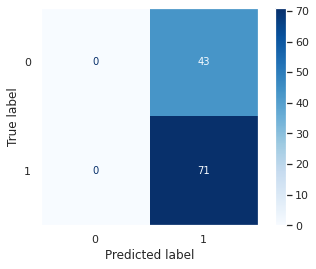

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(dummy_clf, X_test, y_test, cmap="Blues")
plt.grid(None);

La salida es una matriz de dos por dos, donde las filas corresponden a las clases verdaderas y las columnas corresponden a las clases predichas. Las entradas en la diagonal principal de la matriz de confusión corresponden a las clasificaciones correctas, mientras que las entradas por fuera de la diagonal nos dicen cuántas muestras de una clase se clasificaron erróneamente como otra clase, por lo que relacionamos estas entradas con los términos falso positivo y falso negativo que mencionamos anteriormente

![](https://i.imgur.com/Yemljvr.png)

 Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que la matriz de confusión tendría valores distintos de cero solo en su diagonal principal.

Con esta matriz es ahora claro que tenemos un modelo *dummy* que siempre predice la cláse más frecuente. 

Veamos la matriz de confusión para los otros modelos que construimos:

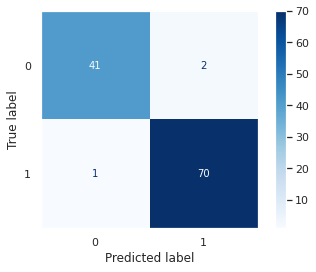

In [ ]:
plot_confusion_matrix(lr_clf, X_test, y_test, cmap="Blues")
plt.grid(None);

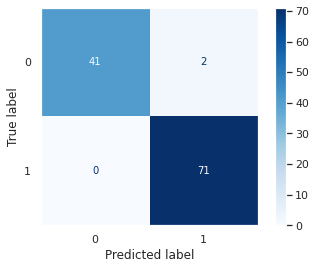

In [ ]:
plot_confusion_matrix(svm_clf, X_test, y_test, cmap="Blues")
plt.grid(None);

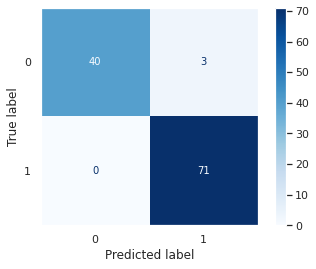

In [ ]:
plot_confusion_matrix(nb_clf, X_test, y_test, cmap="Blues")
plt.grid(None);

Vemos que los tres modelos tienen un mejor rendimiento en todos los aspectos respecto al clasificador *dummy*: tienen más positivos verdaderos y negativos verdaderos mientras que tiene menos falsos positivos y falsos negativos.

La matriz de confusión nos brinda mucha información muy útil. Especialmente en el caso de clasificación multinomial, nos permite interpretar fácilmente los resultados del modelo. Sin embargo, inspeccionar la matriz de confusión completa es un poco engorroso, y además no tienen un parámetro que podamos variar para ver cómo se alteran los modelos, por lo que en muchas ocaciones vamos a querer utilizar una métrica más concreta.

<p><a name="pre"></a></p>

# **Precision & Recall**: 

Hay otras formas de resumir la matriz de confusión: *precision* y *recall*. 

* *precision* es la proporción de predicciones positivas verdaderas con respecto al número total de predicciones positivas:

  $$\text{P} = \frac{TP}{TP + FP}$$

  Esta mide cuántas de las muestras predichas como positivas son realmente positivas. se utiliza como una métrica de rendimiento cuando el objetivo es limitar el número de falsos positivos



In [ ]:
from sklearn.metrics import precision_score

precision_score(y_test, lr_clf.predict(X_test))

0.9722222222222222

Una forma trivial de tener una *precision* perfecta es hacer una sola predicción positiva y asegurarse de que sea correcta (*precision* = 1/1 = 100%). Esto no sería muy útil ya que el clasificador ignoraría todas las instancias positivas menos una. Por lo tanto, la *precision* se usa normalmente junto con otra métrica llamada *recall*

* *recall* es la proporción de predicciones positivas verdaderas respecto al número total de instancias positivas

  $$\text{R} = \frac{TP}{TP+FN}$$

  Esta mide la proporción de clases positivas clasificadas correctamente. El *recall* se utiliza como métrica de rendimiento cuando necesitamos identificar todas las muestras positivas; es decir, cuando es importante evitar falsos negativos.


In [ ]:
from sklearn.metrics import recall_score

recall_score(y_test, lr_clf.predict(X_test))

0.9859154929577465

En nuestro caso quisieramos tener un alto *recall* para evitar el mayor número de falsos negativos posibles. Es muy importante entonces elegir la métrica correcta, de acuerdo al objetivo del problema, y de la repercusión de los posibles errores para seleccionar entre diferentes modelos.

### **Precision/Recall trade-off**

Con frecuencia hay tensión entre la *precision* y el *recall*. Esto quiere decir que, al mejorar la *precision*, generalmente se reduce el *recall*, y viceversa. Esto se denomina *trade-off* de *precision*/*recall*. 

Para comprender este *trade-off*, recordemos cómo los modelos toman sus decisiones de clasificación: Para cada instancia, se calcula una puntuación basada en una función de decisión, y si esa puntuación es mayor o igual que un umbral, se asigna la instancia a la clase positiva o, de lo contrario, se asigna a la clase negativa.

En la siguiente figura vemos los valores de *precision* P y *recall* R para tres valores del umbral (-5, 0 y 5). Note que cuando el umbral es cero, ambos puntajes coinciden para este caso particular. A medida que se disminuye el umbral, el *recall* aumenta mientras que la *precision* disminuye. Por el contrario, si el umbral aumenta, la *precision* aumenta mientras que el *recall* disminuye

![](https://i.imgur.com/AudrFsH.png)

Podemos lograr un buen *trade-off* de *precision/recall* por varios medios:

* Asignando un mayor peso a las instancia de una clase específica. Por ejemplo, el estimador `SVC` de Sklearn tiene el hiperparámetro `class_weight` con el cual podemos asignar un peso particular a las clases.

* Ajustando los hiperparámetros para maximizar la *precision* o el *recall* en el conjunto de validación.

* Variando el umbral de decisión de los algoritmos que devuelven puntuaciones de predicción.

Veamos este último en el caso de la regresión logística. En nuestro caso es más importante tener un alto *recall*. Esto significa que estamos dispuestos a arriesgar más falsos positivos a cambio de disminuir los falsos negativos. 

Sklearn no nos permite establecer el umbral directamente, pero nos da acceso a los puntajes de decisión que utiliza para hacer las predicciones con el el método `decision_function`






In [ ]:
lr_clf.decision_function(X_test)

array([  2.04728073, -11.61392569,  -5.77378482,   7.57870279,
         9.70649132, -23.06567557, -20.27168162,  -3.31281742,
         0.48655175,   7.17535158,   2.94477792,  -4.37555516,
         5.09850878,  -1.768838  ,   6.41771734,  -7.17950628,
         6.28487423,  11.38897714,  14.00314398, -13.6819349 ,
         2.3840794 ,   4.61757595, -19.2343191 ,   9.43958918,
         6.76938887,   7.44939701,   6.82447154,   5.10103047,
         5.85024439, -11.72170476,   7.56178459,   8.80890154,
         6.11365994,   5.19486672,   8.85865079,   6.00962733,
        -2.79024911,   5.82142916,  -9.31974505,   2.97989307,
         9.53828961,  -7.81133713,   5.99536086,   6.93439865,
         3.88154364,   2.54658098,   7.80947494,   7.60467735,
         3.44912852,   7.39456363,  -9.02384345, -16.73573683,
         0.80363685,   4.30701089,  10.49873152,   4.63063476,
         9.07907833, -25.60640198,  -1.63368407,   8.86911142,
         5.28693079, -14.61037882, -20.36438644,   3.43

Como ya sabemos, por defecto, los puntos con un valor de función de decisión mayor que 0 se clasificarán como clase 1

In [ ]:
lr_clf.predict(X_test)

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0])

Queremos que se clasifiquen más puntos como clase 1, por lo que debemos disminuir el umbral. 

Como vimos, el hacer predicciones puede verse como fijar el umbral para la salida de la función de decisión en un cierto punto fijo. Entonces, En lugar de llamar al método `predict` del clasificador, podemos llamar al método `decision_function`, que devuelve una puntuación para cada instancia, y luego hacer predicciones basadas en esas puntuaciones utilizando cualquier umbral que deseemos. Por ejemplo, realicemos predicciones sobre el conjunto de prueba disminuyendo el umbral a -0.8:



In [ ]:
y_pred_lower_threshold = lr_clf.decision_function(X_test) > -.8
y_pred_lower_threshold

array([ True, False, False,  True,  True, False, False, False,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True, False, False,  True,  True,  True, False,
        True,  True, False,  True,  True, False])

recordemos que python interpreta `True` como 1 y `False` como 0

In [ ]:
y_pred_lower_threshold.astype("int")

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0])

Veamos los puntajes de *precision* y *recall*

In [ ]:
recall_score(y_test, y_pred_lower_threshold)

1.0

In [ ]:
precision_score(y_test, y_pred_lower_threshold)

0.9726027397260274

Vemos que efectivamente el *recall* aumento a uno, mientras que la *precision* no disminuyo significativamente.

De esta forma es posible crear un clasificador con prácticamente cualquier *recall* que se desee: simplemente se establece un umbral lo suficientemente bajo. Sin embargo, debemos tener presente que un clasificador con un *recall* alto no es muy útil si su *precision* es demasiado bajo.

¿Cómo podemos decidir qué umbral usar? Podemos construir una curva que nos muestre los puntajes de *precision* y *recall* para diferentes valores del umbral utilizando la función `precision_recall_curve`. Para esto, primero debemos obtener las predicciones de todas las instancias en el conjunto de entrenamiento utilizando la función `cross_val_predict`

In [ ]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(lr_clf, X_train, y_train, method="decision_function")

Ahora, con estos puntajes, podemos calcular la *precision* y el *recall* para todos los umbrales posibles 

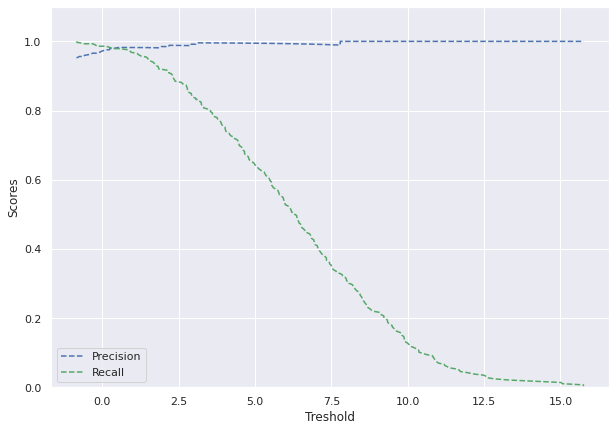

In [ ]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

P, R, T = precision_recall_curve(y_train, y_scores)

plt.figure(figsize=(10,7))
plt.plot(T, P[:-1], "b--", label="Precision")
plt.plot(T, R[:-1], "g--", label="Recall")
plt.xlabel("Treshold")
plt.ylabel("Scores")
plt.ylim(0, 1.1)
plt.legend();

De aquí, podemos seleccionar el valor de umbral que nos brinde el mejor trade-off de *precision*/*recall* para nuestra tarea. Otra forma de seleccionar un buen  trade-off es graficar la *precision* directamente contra el *recall*:



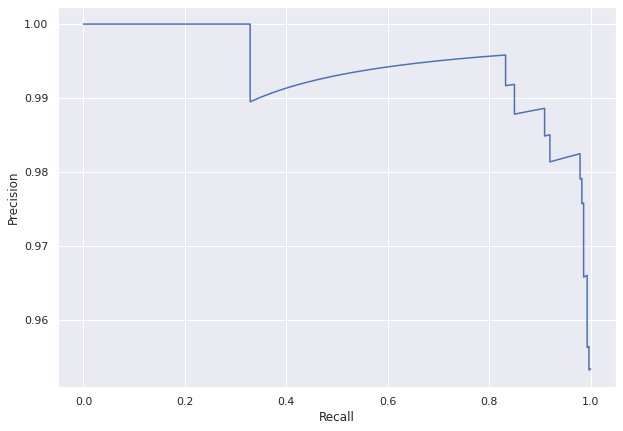

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(R, P)
plt.ylabel("Precision")
plt.xlabel("Recall");

Un área debajo de la curva grande representa alto *recall* y *precision*, donde una *precision* alta se relaciona con una tasa baja de falsos positivos y un alto *recall* se relaciona con una tasa baja de falsos negativos. 


### **f score**

Si bien la *precision* y el *recall* son medidas muy importantes, mirar solo una de ellas no proporcionará una imagen completa del problema. Una forma de resumir la *precision* y el *recall* es el *puntaje f* o la *medida f*, que es la media armónica entre *precision* y *recall*

$$\text{f} = 2 \frac{P*R}{P+R}$$

Mientras que la media trata todos los valores por igual, la media armónica da mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación *f* alta si tanto el *recall* como la *precision* son altas

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, lr_clf.predict(X_test))

0.979020979020979

Como tiene en cuenta la *precision* y el *recall*, esta puede ser una mejor medida que la *accuracy* en los conjuntos de datos de clasificación binaria no balanceados. El puntaje f favorece a los clasificadores que tienen una *precision* y un *recall* similares.




<p><a name="cur"></a></p>

# **Curva ROC**

La curva ROC (*receiver operating characteristic*) es un método de uso común para evaluar modelos de clasificación. Las curvas ROC usan una combinación de la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para construir una imagen resumida del desempeño de la clasificación

$$
\text{TPR} = \text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

El FPR es la proporción de instancias negativas que se clasifican incorrectamente como positivas. 

Podemos obtener esta curva con la función `plot_roc_curve` de Sklearn

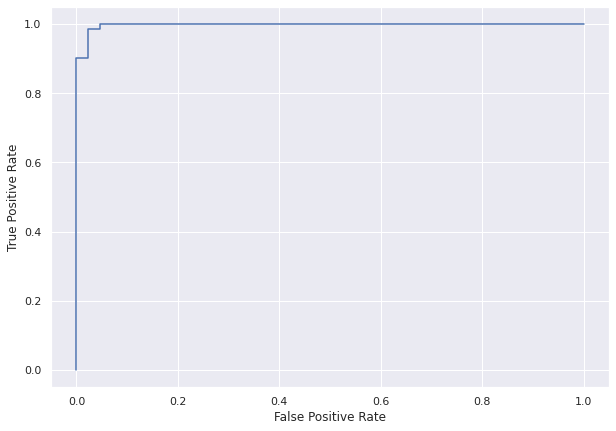

In [ ]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(10,7))
plot_roc_curve(lr_clf, X_test, y_test, ax=ax)
ax.legend().remove();

Si el umbral es igual a 0, todas las predicciones serán positivas, por lo que tanto la tasa de verdaderos positivos como la tasa de falsos positivos serán igual a 1 (la esquina superior derecha).

Por otro lado, si el umbral es igual a 1, entonces no será posible una predicción positiva, por lo que tanto la tasa de verdaderos positivos como la tasa de falsos positivos serán iguales a 0 (TP = 0), que corresponde a la esquina inferior izquierda.

Veamos algunos casos extremos para entender un poco mejor cómo interpretar esta curva ROC:




* En la siguiente figura se muestran las regiones de decisión: azul para la clase negativa y naranja para la clase positiva. También se muestran las distribuciones de probabilidad para las clases positivas (naranja) y negativas (azul). Note que en este caso, **todas las predicciones son correctas**. La curva ROC, en este caso, tendrá la forma de la derecha

![](https://i.imgur.com/uAX1CXQ.png)

* En el caso en el que **todas las predicciones sean incorrectas**, como se ve en la figura de la izquierda, la curva ROC tendrá la forma de la derecha:

![](https://i.imgur.com/5RHNFO0.png)

* En el caso en el que **las predicciones sean aleatorias**, como se muestra en la figura de la izquierda, la curva ROC tendrá la forma de la derecha:

![](https://i.imgur.com/ZkgY9L0.png)

En conclusión, el mejor modelo será aquel cuya curva ROC se acerque más a la esquina superior izquierda. 

Note que una forma resumida de evaluar los clasificadores es con el área bajo la curva ROC: Cuanto mayor sea el área bajo la curva ROC (AUC), mejor será el clasificador. Un clasificador con un AUC superior a 0.5 es mejor que un modelo que clasifica al azar. Si el AUC es inferior a 0.5, entonces algo está realmente mal, lo más probable es que haya un error en el código o que hayan etiquetas incorrectas en los datos. Un clasificador perfecto tendría un AUC de 1.  

Sklearn proporciona la función `roc_auc_score` para calcular el AUC de la curva ROC:



In [ ]:
from sklearn.metrics import roc_auc_score

lr_pred = cross_val_predict(lr_clf, X_train, y_train)

roc_auc_score(y_train, lr_pred)

0.9722969338353954

Veamos las curvas ROC para los clasificadores que hemos estado utilizando con sus respectivas AUC:

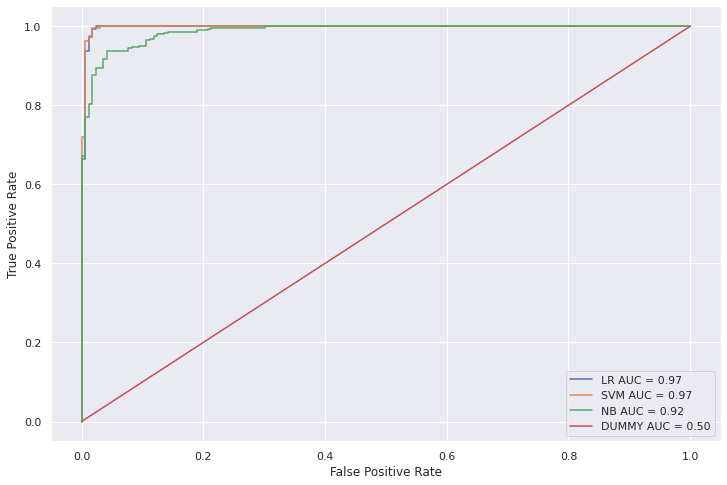

In [ ]:
svm_pred = cross_val_predict(svm_clf, X_train, y_train)
nb_pred = cross_val_predict(nb_clf, X_train, y_train)
dummy_pred = cross_val_predict(dummy_clf, X_train, y_train)

fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(lr_clf, X_train, y_train, label=f"LR AUC = {roc_auc_score(y_train, lr_pred):.2f}", ax=ax)
plot_roc_curve(svm_clf, X_train, y_train, label=f"SVM AUC = {roc_auc_score(y_train, svm_pred):.2f}",ax=ax)
plot_roc_curve(nb_clf, X_train, y_train, label=f"NB AUC = {roc_auc_score(y_train, nb_pred):.2f}",ax=ax)
plot_roc_curve(dummy_clf, X_train, y_train, label=f"DUMMY AUC = {roc_auc_score(y_train, dummy_pred):.2f}",ax=ax)
plt.legend();

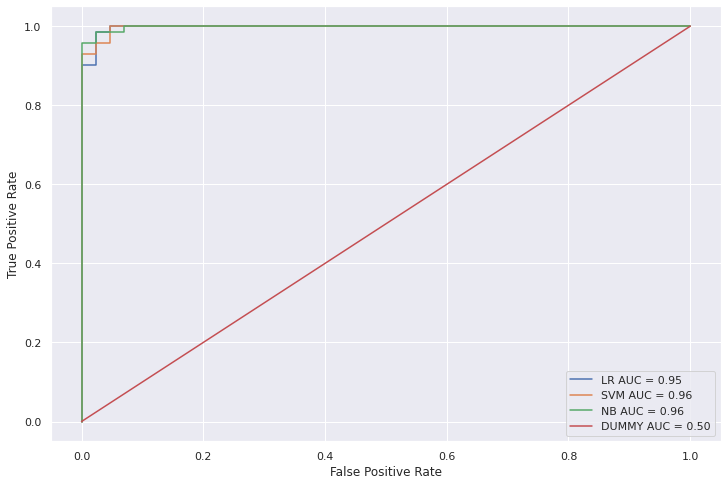

In [ ]:
lr_pred = cross_val_predict(lr_clf, X_test, y_test)
svm_pred = cross_val_predict(svm_clf, X_test, y_test)
nb_pred = cross_val_predict(nb_clf, X_test, y_test)
dummy_pred = cross_val_predict(dummy_clf, X_test, y_test)

fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(lr_clf, X_test, y_test, label=f"LR AUC = {roc_auc_score(y_test, lr_pred):.2f}", ax=ax)
plot_roc_curve(svm_clf, X_test, y_test, label=f"SVM AUC = {roc_auc_score(y_test, svm_pred):.2f}",ax=ax)
plot_roc_curve(nb_clf, X_test, y_test, label=f"NB AUC = {roc_auc_score(y_test, nb_pred):.2f}",ax=ax)
plot_roc_curve(dummy_clf, X_test, y_test, label=f"DUMMY AUC = {roc_auc_score(y_test, dummy_pred):.2f}",ax=ax)
plt.legend();

De aquí vemos que los mejores modelos se encuentran con la regresión logística (LR) y con las máquinas de vectores de soporte (SVM).

En la práctica, se obtiene un buen clasificador seleccionando el valor del umbral que da la tasa de verdaderos positivos cerca de 1, manteniendo la tasa de falsos positivos cerca de 0.

